In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pymatgen.core import Structure
from IPython.display import display

# Minimal imports from your modules (adjust paths as needed):
from bin.evaluate import load_model_from_checkpoint
from bin.train import TrainConfig
from decifer.tokenizer import Tokenizer
from decifer.utility import (
    pxrd_from_cif,
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop
)
import crystal_toolkit

def read_experimental_data(zip_path):
    """
    Reads and combines all .xy or .xye files in the zip,
    maps them to their compositions, returns a single DataFrame.
    """
    # Read Jens composition Excel
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open('experimental_data/Jens/Compositions.xlsx') as f:
            df_jens_comp = pd.read_excel(f, engine='openpyxl')
    df_jens_comp['Name_lower'] = df_jens_comp['Name'].str.lower()
    
    def get_jens_composition(fname):
        fname_lower = fname.lower()
        for _, row in df_jens_comp.iterrows():
            if row['Name_lower'] in fname_lower:
                return row['Composition']
        return None
    
    frames = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for info in z.infolist():
            if info.is_dir():
                continue
            fn = info.filename
            if not (fn.endswith('.xy') or fn.endswith('.xye')):
                continue
            
            with z.open(fn) as f:
                lines = f.read().decode('utf-8').splitlines()
            
            folder = os.path.basename(os.path.dirname(fn))
            base_name = os.path.basename(fn)
            # Infer composition
            if folder.lower() == 'jens':
                comp_str = get_jens_composition(base_name)
            elif folder.lower() == 'laura_irox':
                if 'irox' in base_name.lower():
                    comp_str = 'IrOx'
                elif 'iro2' in base_name.lower():
                    comp_str = 'IrO2'
                else:
                    comp_str = 'Ir-based oxide'
            elif folder.lower() == 'nicolas':
                subfolder = fn.split('/')[-2]
                if 'fcc pure' in subfolder.lower():
                    comp_str = 'Pt (fcc)'
                elif 'fcc+fct' in subfolder.lower():
                    comp_str = 'Pt (fcc+fct)'
                else:
                    comp_str = 'Pt-based'
            elif folder.lower() == 'rebecca_ceo2':
                comp_str = 'CeO2'
            else:
                comp_str = None

            records = []
            for line in lines:
                parts = line.split()
                if len(parts) == 2:
                    angle, intensity = parts
                    records.append((float(angle), float(intensity), None))
                elif len(parts) == 3:
                    angle, intensity, error = parts
                    records.append((float(angle), float(intensity), float(error)))

            df_temp = pd.DataFrame(records, columns=['angle', 'intensity', 'error'])
            df_temp['composition'] = comp_str
            df_temp['source_file'] = base_name
            df_temp['source_folder'] = folder
            frames.append(df_temp)

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def standardize_signal(df, q_col, intensity_col, q_min=0.0, q_max=10.0, n_points=1000):
    df = df.drop_duplicates(subset=q_col).sort_values(by=q_col)
    q_new = np.linspace(q_min, q_max, n_points)
    i_new = np.interp(q_new, df[q_col], df[intensity_col])
    return pd.DataFrame({"Q": q_new, intensity_col: i_new})

TOKENIZER = Tokenizer()
START_ID = TOKENIZER.token_to_id["data_"]
ENCODE = TOKENIZER.encode
TOKENIZE = TOKENIZER.tokenize_cif
DECODE = TOKENIZER.decode

def load_custom_model(model_path, device="cuda"):
    return load_model_from_checkpoint(model_path, device=device)

def fix_symmetry_in_cif(cif_string):
    c = replace_symmetry_loop_with_P1(cif_string)
    sg = extract_space_group_symbol(c)
    return reinstate_symmetry_loop(c, sg) if sg != "P 1" else c

def generate_cif(model, cond_vec, composition=None, spacegroup=None, max_new_tokens=3000):
    prompt = torch.tensor([START_ID]).unsqueeze(0).to(model.device)
    if composition:
        comp_str = f"data_{composition}\n"
        c_tokens = ENCODE(TOKENIZE(comp_str))
        prompt = torch.tensor(c_tokens).unsqueeze(0).to(model.device)
    out = model.generate_custom(
        idx=prompt,
        max_new_tokens=max_new_tokens,
        cond_vec=cond_vec,
        start_indices_batch=[[0]],
        composition_string=composition,
        spacegroup_string=spacegroup
    ).cpu().numpy()
    return DECODE(out[0])

def run_decifer_generation(model_path, cond_array, composition=None, spacegroup=None,
                           device="cuda", do_plot=False, q_exp=None, i_exp=None):
    model = load_custom_model(model_path, device=device)
    if not isinstance(cond_array, torch.Tensor):
        cond_array = torch.tensor(cond_array)
    cond_array = cond_array.unsqueeze(0).to(model.device).float()

    cif_raw = generate_cif(model, cond_vec=cond_array, composition=composition, spacegroup=spacegroup)
    cif_fixed = fix_symmetry_in_cif(cif_raw)
    structure = Structure.from_str(cif_fixed, fmt="cif")
    pxrd_dict = pxrd_from_cif(cif_fixed, base_fwhm=0.0125)

    if do_plot and (q_exp is not None) and (i_exp is not None):
        plt.plot(q_exp, i_exp, label="Experimental")
        plt.plot(pxrd_dict["q"], pxrd_dict["iq"], label="Simulated")
        plt.xlabel("Q (Å$^{-1}$)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()
        display(structure)

    return cif_fixed, structure, pxrd_dict

def preprocess_generic(df, target_file, 
                       wavelength=0.25448, q_min_crop=1.0, q_max_crop=8.0,
                       n_points=1000):
    # Filter
    df_sel = df[
        (df['source_file'].str.lower() == target_file.lower())
    ].copy()

    # Convert angle → Q
    theta_rad = np.radians(df_sel["angle"] / 2.0)
    df_sel["Q"] = (4.0 * np.pi / wavelength) * np.sin(theta_rad)

    # Normalize
    maxI = df_sel["intensity"].max(skipna=True)
    df_sel["intensity_norm"] = df_sel["intensity"] / maxI

    # Crop for baseline removal
    df_crop = df_sel[
        (df_sel["Q"] >= q_min_crop) & (df_sel["Q"] <= q_max_crop)
    ].copy()
    min_val = df_crop["intensity"].min(skipna=True)
    df_crop["intensity_baseline_zero"] = df_crop["intensity"] - min_val
    max_shift = df_crop["intensity_baseline_zero"].max(skipna=True)
    df_crop["intensity_baseline_zero_norm"] = df_crop["intensity_baseline_zero"] / max_shift
    
    # Standardize signals
    df_std_raw = standardize_signal(df_sel, "Q", "intensity_norm",
                                    q_min=0.0, q_max=10.0, n_points=n_points)
    df_std_base = standardize_signal(df_crop, "Q", "intensity_baseline_zero_norm",
                                     q_min=0.0, q_max=10.0, n_points=n_points)

    return df_sel, df_crop, df_std_raw, df_std_base

def standardize_signal(df, q_col, intensity_col, q_min=0.0, q_max=10.0, n_points=1000):
    df = df.drop_duplicates(subset=q_col).sort_values(by=q_col)
    q_new = np.linspace(q_min, q_max, n_points)
    i_new = np.interp(q_new, df[q_col], df[intensity_col])
    return pd.DataFrame({q_col: q_new, intensity_col: i_new})

In [3]:
# Adjust as needed:
zip_path = "experimental_data.zip"
df_all = read_experimental_data(zip_path)

In [ ]:
target_file = 'scan-4919_mean.xy'

df_sample, df_sample_crop, df_sample_std_raw, df_sample_std_base = preprocess_generic(
    df_all,
    target_file=target_file,
    wavelength=0.35425,
    q_min_crop=0.5, 
    q_max_crop=5.0
)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_sample_std_raw["Q"], df_sample_std_raw["intensity_norm"], label="Raw norm")
ax.plot(df_sample_std_base["Q"], df_sample_std_base["intensity_baseline_zero_norm"], label="Std Baseline")
ax.legend()
plt.show()

# If you have a trained model checkpoint:
model_path = "../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt"
cif_str, struct, pxrd_out = run_decifer_generation(
    model_path=model_path,
    cond_array=df_sample_std_base["intensity_baseline_zero_norm"].values,
    composition="Ce4O8",
    # spacegroup=None,
    device="cuda",
    do_plot=True,
    q_exp=df_sample_std_base["Q"].values,
    i_exp=df_sample_std_base["intensity_baseline_zero_norm"].values
)

In [34]:
df_all["source_file"].unique()

array(['crystalline_CeO2_BM31.xye', 'JEP_HEO1.1_D8.xy',
       'spinel1_BM31.xye', 'spinel2_BM31.xye', 'spinel3_BM31.xye',
       'spinel4_BM31.xye', 'spinel5_BM31.xye', 'IrO2_3nm_30minXRD.xy',
       'IrO2_9nmRod_30minXRD.xy', 'IrOx_0p8nm_30minXRD.xy',
       'IrOx_1nm_30minXRD.xy', 'NS_PtHEI_300C180m.xy',
       'NS_PtHEI_300C90m.xy', 'NS_PtHEI_300C_360m_4h.xye',
       'NS_PtHEI_350C_120m.xye', 'NS_PtHEI_350C_240m.xye',
       'ESRF_IB_06_0001_2th_PtHEI.xye', 'NS_PtHEI_400C180m.xy',
       'NS_PtHEI_550C60m.xy', 'NS_PtHEI_550C_120m_4h.xye',
       'NS_PtHEI_700C_90m.xye', 'boroglass_0p8_empty_VCT_72h.xy',
       'Hydrolyse_ID10_20min_3-56_boro_0p8.xy',
       'Hydrolyse_ID5_20min_3-56_boro_0p8.xy',
       'Hydrolyse_ID6_20min_3-56_boro_0p8.xy',
       'Hydrolyse_ID8_20min_3-56_boro_0p8.xy', 'scan-4903_mean.xy',
       'scan-4907_mean.xy', 'scan-4911_mean.xy', 'scan-4912_mean.xy',
       'scan-4919_mean.xy'], dtype=object)

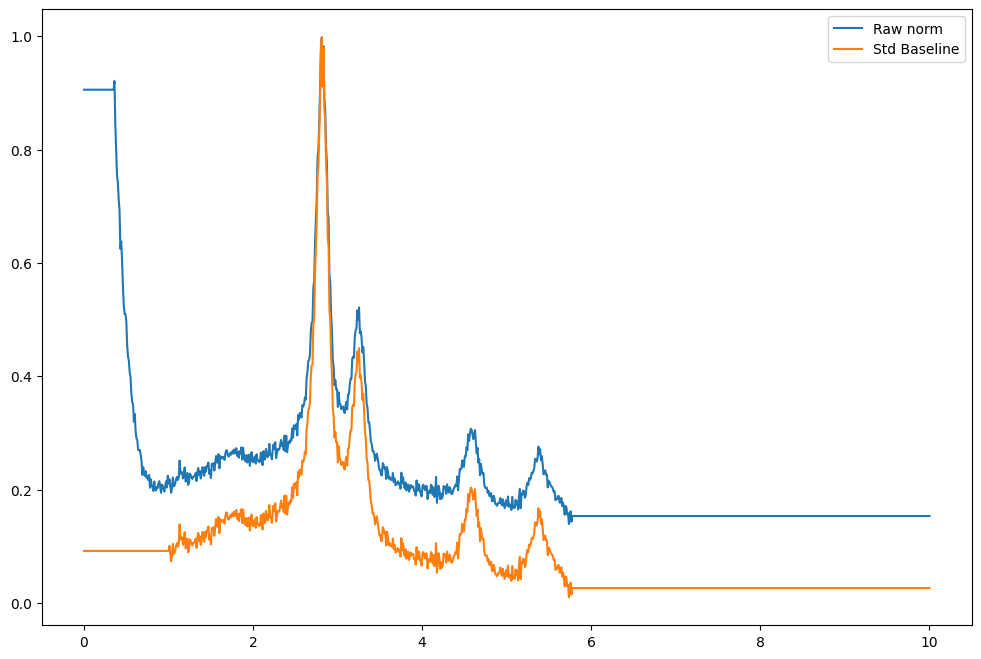

In [42]:
target_file = 'NS_PtHEI_300C90m.xy'

df_sample, df_sample_crop, df_sample_std_raw, df_sample_std_base = preprocess_generic(
    df_all,
    target_file=target_file,
    wavelength=1.54,
    q_min_crop=1.0, 
    q_max_crop=20.0
)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_sample_std_raw["Q"], df_sample_std_raw["intensity_norm"], label="Raw norm")
ax.plot(df_sample_std_base["Q"], df_sample_std_base["intensity_baseline_zero_norm"], label="Std Baseline")
ax.legend()
plt.show()

number of total non-trainable parameters: 26.14M
number of total trainable parameters: 27.72M
number of total conditioning MLP parameters: 0.78M


Generating custom sequence:   0%|          | 0/3000 [00:00<?, ?it/s]

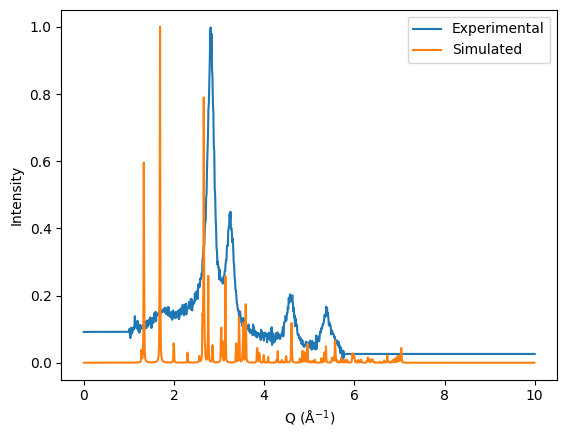

In [47]:
# If you have a trained model checkpoint:
model_path = "../../deCIFer/experiments/model__conditioned_mlp_augmentation__context_3076__robust/ckpt.pt"
cif_str, struct, pxrd_out = run_decifer_generation(
    model_path=model_path,
    cond_array=df_sample_std_base["intensity_baseline_zero_norm"].values,
    # composition="Pt",
    # spacegroup=None,
    device="cuda",
    do_plot=True,
    q_exp=df_sample_std_base["Q"].values,
    i_exp=df_sample_std_base["intensity_baseline_zero_norm"].values
)